# Run inference on pre-trained model:

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
from tqdm.auto import tqdm
from torch.nn.functional import softmax

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from grace.base import GraphAttrs, Annotation

from grace.models.classifier import GCN
from grace.models.optimiser import optimise_graph
from grace.simulator.simulate_graph import random_graph

from grace.evaluation.visualisation import (
    plot_simple_graph,
    plot_connected_components,
)

from grace.evaluation.process import (
    generate_ground_truth_graph,
    update_graph_with_dummy_predictions,
    assume_annotations_from_dummy_predictions,
    # assume_dummy_predictions_from_annotations,
    # add_and_remove_random_edges,
)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <B5FD9895-F13C-386E-85C3-E2998159857E> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


### Nominate a pre-trained GCN model:

In [3]:
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-01_20-51-45/classifier.pt"
classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-03_14-35-24/classifier.pt"
pre_trained_gcn = torch.load(classifier_filename)
pre_trained_gcn.eval()


GCN(
  (node_classifier): Linear(in_features=4, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=8, out_features=2, bias=True)
)

In [4]:
pre_trained_gcn

GCN(
  (node_classifier): Linear(in_features=4, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=8, out_features=2, bias=True)
)

In [5]:
MOTIFS = ["line", ]
N_MOTIFS = 3
DENSITY = 0.01

def generate_random_optimised_and_GT_graphs():
    G = random_graph(
        n_motifs=N_MOTIFS, 
        density=DENSITY, 
        motifs=MOTIFS
    )
    node_conf, edge_conf = 0.5, 0.1
    update_graph_with_dummy_predictions(
        G, 
        node_confidence=node_conf, 
        edge_confidence=edge_conf
    )
    assume_annotations_from_dummy_predictions(G)
    true_graph = generate_ground_truth_graph(G)
    pred_graph = optimise_graph(G)

    return G, pred_graph, true_graph

In [6]:
synthesize = True
counter = 0

while synthesize:
    counter += 1
    print (f"Synthesizing imperfectly optimised graph: iter = {counter}")

    G, pred_graph, true_graph = generate_random_optimised_and_GT_graphs()
    node_con = pred_graph.number_of_nodes() == true_graph.number_of_nodes()
    edge_con = pred_graph.number_of_edges() != true_graph.number_of_edges()
    
    if node_con and edge_con:
        synthesize = False


Synthesizing imperfectly optimised graph: iter = 1


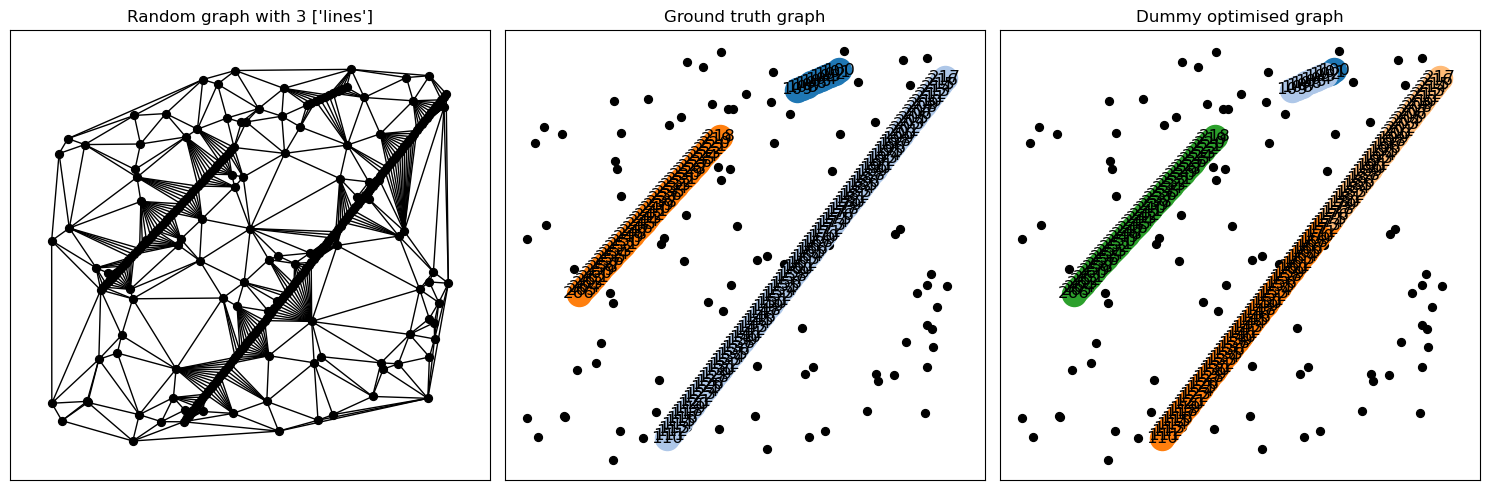

In [7]:
shape = 5
_, axes = plt.subplots(1, 3, figsize=(shape*3, shape*1))

plot_simple_graph(G, title=f"Random graph with {N_MOTIFS} {MOTIFS}", ax=axes[0])
plot_connected_components(true_graph, title=f"Ground truth graph", ax=axes[1])
plot_connected_components(pred_graph, title=f"Dummy optimised graph", ax=axes[2])

plt.tight_layout()
plt.show()

### Create a dummy feature vector for nodes:

In [8]:
for _, node in G.nodes(data=True):
    feature = np.random.random() * 0.5
    if node["label"] > 0:
        feature = 1 - feature
    
    # Create the tensor
    num_repeats = 4
    features = torch.full((num_repeats,), fill_value=feature, dtype=torch.float32)
    node[GraphAttrs.NODE_FEATURES] = features.squeeze()


### Predict the node & edge probs:

In [9]:
from grace.models.datasets import dataset_from_graph

In [10]:
# inf_dataset = dataset_from_graph(G, mode="whole", in_train_mode=False)
sub_dataset = dataset_from_graph(G, mode="sub", in_train_mode=False)
len(sub_dataset)

267

In [11]:
for d, data in enumerate(sub_dataset):
    print (d, data)
    break


0 Data(x=[7, 4], edge_index=[2, 11], edge_attr=[7, 2], y=[7], pos=[7, 2], edge_label=[11])


In [12]:
data.x, data.edge_index

(tensor([[0.1373, 0.1373, 0.1373, 0.1373],
         [0.0730, 0.0730, 0.0730, 0.0730],
         [0.1953, 0.1953, 0.1953, 0.1953],
         [0.2104, 0.2104, 0.2104, 0.2104],
         [0.0021, 0.0021, 0.0021, 0.0021],
         [0.6763, 0.6763, 0.6763, 0.6763],
         [0.2136, 0.2136, 0.2136, 0.2136]]),
 tensor([[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4],
         [1, 5, 6, 2, 4, 3, 5, 3, 6, 5, 6]]))

### Get the predictions:

In [13]:
node_softmax_preds = []
edge_softmax_preds = []
node_argmax_preds = []
edge_argmax_preds = []
node_labels = []
edge_labels = []


for data in tqdm(sub_dataset, desc="Predicting for individual subgraphs: "):

    # Predict labels from sub-graph:
    result = pre_trained_gcn.predict(x=data.x, edge_index=data.edge_index)
    node_emb, edge_emb, node_x, edge_x = result
    print (data)
    print ([r.shape for r in result])

    # Process nodes probs into classes predictions:
    node_labels.extend(data.y)
    
    # node_soft = softmax(node_x, dim=1)
    node_soft = node_x.softmax(dim=1)
    node_softmax_preds.extend(node_soft)

    node_arg = node_soft.argmax(dim=1).long()
    node_argmax_preds.extend(node_arg)

    # Process nodes probs into classes predictions:
    edge_labels.extend(data.edge_label)
    
    # edge_soft = softmax(edge_x, dim=1)
    edge_soft = edge_x.softmax(dim=1)
    edge_softmax_preds.extend(edge_soft)

    edge_arg = edge_soft.argmax(dim=1).long()
    edge_argmax_preds.extend(edge_arg)

    # break

# Stack the results:
node_softmax_preds = torch.stack(node_softmax_preds, axis=0)
edge_softmax_preds = torch.stack(edge_softmax_preds, axis=0)
node_argmax_preds = torch.stack(node_argmax_preds, axis=0)
edge_argmax_preds = torch.stack(edge_argmax_preds, axis=0)
node_labels = torch.stack(node_labels, axis=0)
edge_labels = torch.stack(edge_labels, axis=0)

node_softmax_preds.shape, node_argmax_preds.shape, node_labels.shape

Predicting for individual subgraphs: 100%|██████████| 267/267 [00:00<00:00, 7019.51it/s]

Data(x=[7, 4], edge_index=[2, 11], edge_attr=[7, 2], y=[7], pos=[7, 2], edge_label=[11])
[torch.Size([7, 4]), torch.Size([11, 8]), torch.Size([7, 2]), torch.Size([11, 2])]
Data(x=[9, 4], edge_index=[2, 16], edge_attr=[9, 2], y=[9], pos=[9, 2], edge_label=[16])
[torch.Size([9, 4]), torch.Size([16, 8]), torch.Size([9, 2]), torch.Size([16, 2])]
Data(x=[12, 4], edge_index=[2, 22], edge_attr=[12, 2], y=[12], pos=[12, 2], edge_label=[22])
[torch.Size([12, 4]), torch.Size([22, 8]), torch.Size([12, 2]), torch.Size([22, 2])]
Data(x=[6, 4], edge_index=[2, 10], edge_attr=[6, 2], y=[6], pos=[6, 2], edge_label=[10])
[torch.Size([6, 4]), torch.Size([10, 8]), torch.Size([6, 2]), torch.Size([10, 2])]
Data(x=[6, 4], edge_index=[2, 10], edge_attr=[6, 2], y=[6], pos=[6, 2], edge_label=[10])
[torch.Size([6, 4]), torch.Size([10, 8]), torch.Size([6, 2]), torch.Size([10, 2])]
Data(x=[7, 4], edge_index=[2, 11], edge_attr=[7, 2], y=[7], pos=[7, 2], edge_label=[11])
[torch.Size([7, 4]), torch.Size([11, 8]), tor

(torch.Size([1835, 2]), torch.Size([1835]), torch.Size([1835]))

## Evaluation:
### Simple metrics first:

In [14]:
from grace.utils.metrics import (
    accuracy_metric, 
    confusion_matrix_metric, 
    areas_under_curves_metrics,
)

In [15]:
node_acc, edge_acc = accuracy_metric(
    node_argmax_preds, edge_argmax_preds, node_labels, edge_labels
)
node_acc, edge_acc

(0.008174386920980926, 0.8744809964867455)

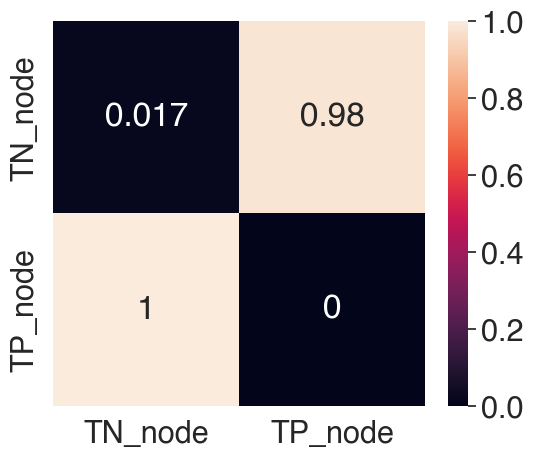

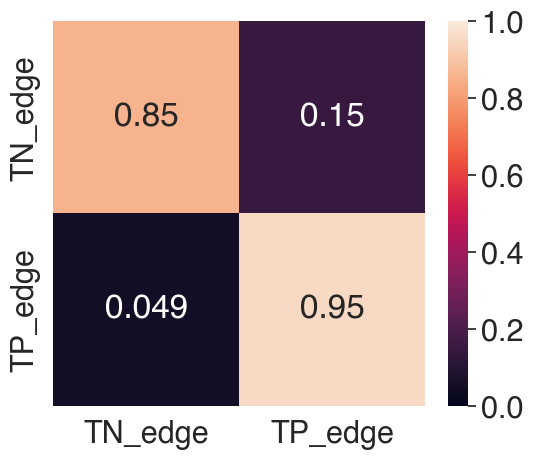

In [16]:
n_cm, e_cm = confusion_matrix_metric(
    node_argmax_preds, edge_argmax_preds, node_labels, edge_labels, normalize="true"
)

In [ ]:
n_cm, e_cm = confusion_matrix_metric(
    node_argmax_preds, edge_argmax_preds, node_labels, edge_labels, normalize=None
)

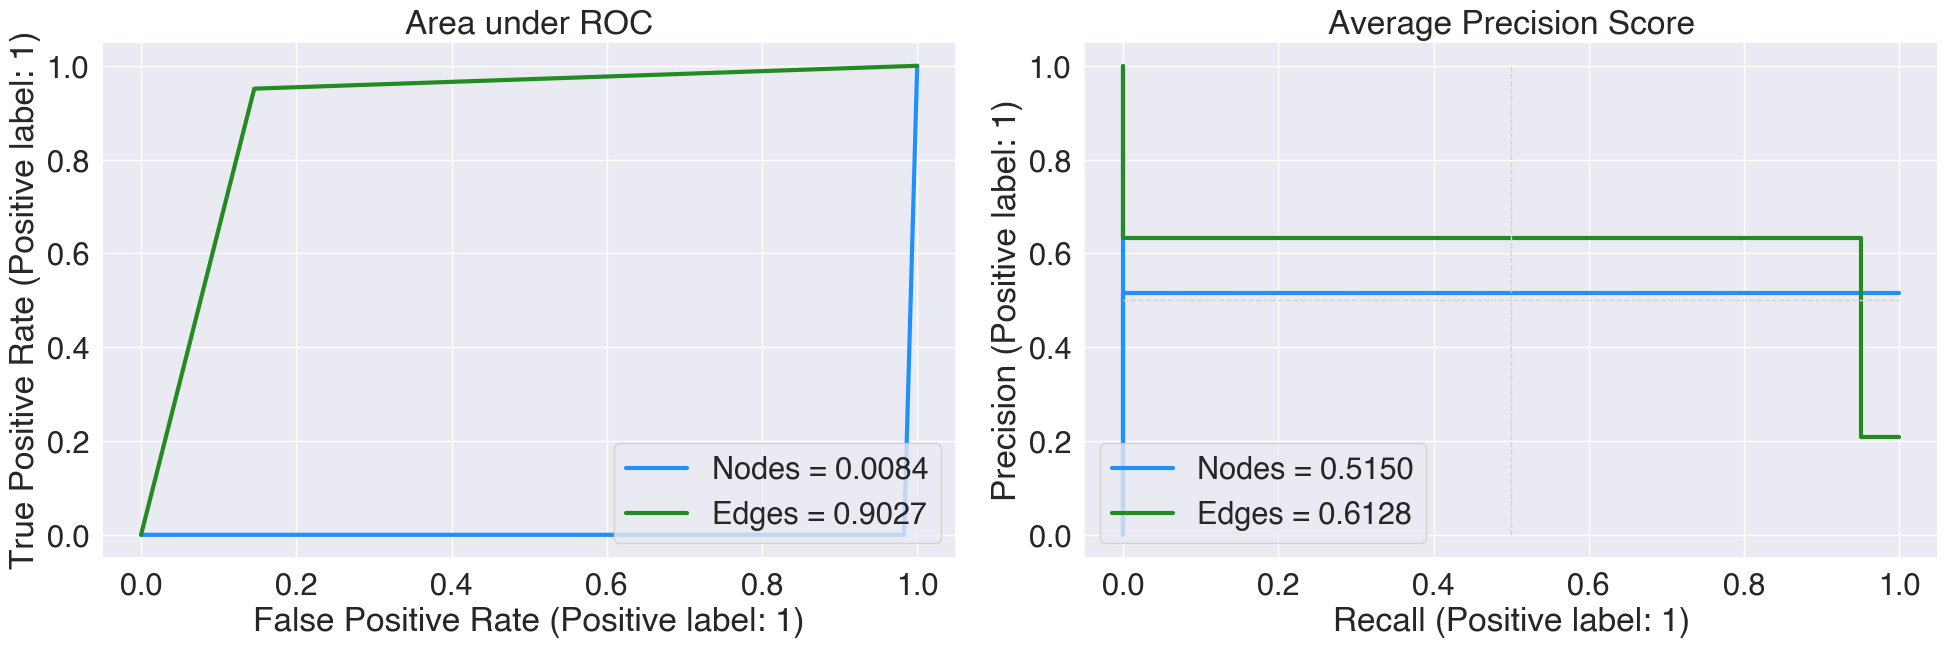

In [17]:
areas_fig = areas_under_curves_metrics(
    node_argmax_preds, edge_argmax_preds, node_labels, edge_labels
)

### Possibly, display all 4 confusion matrices:

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

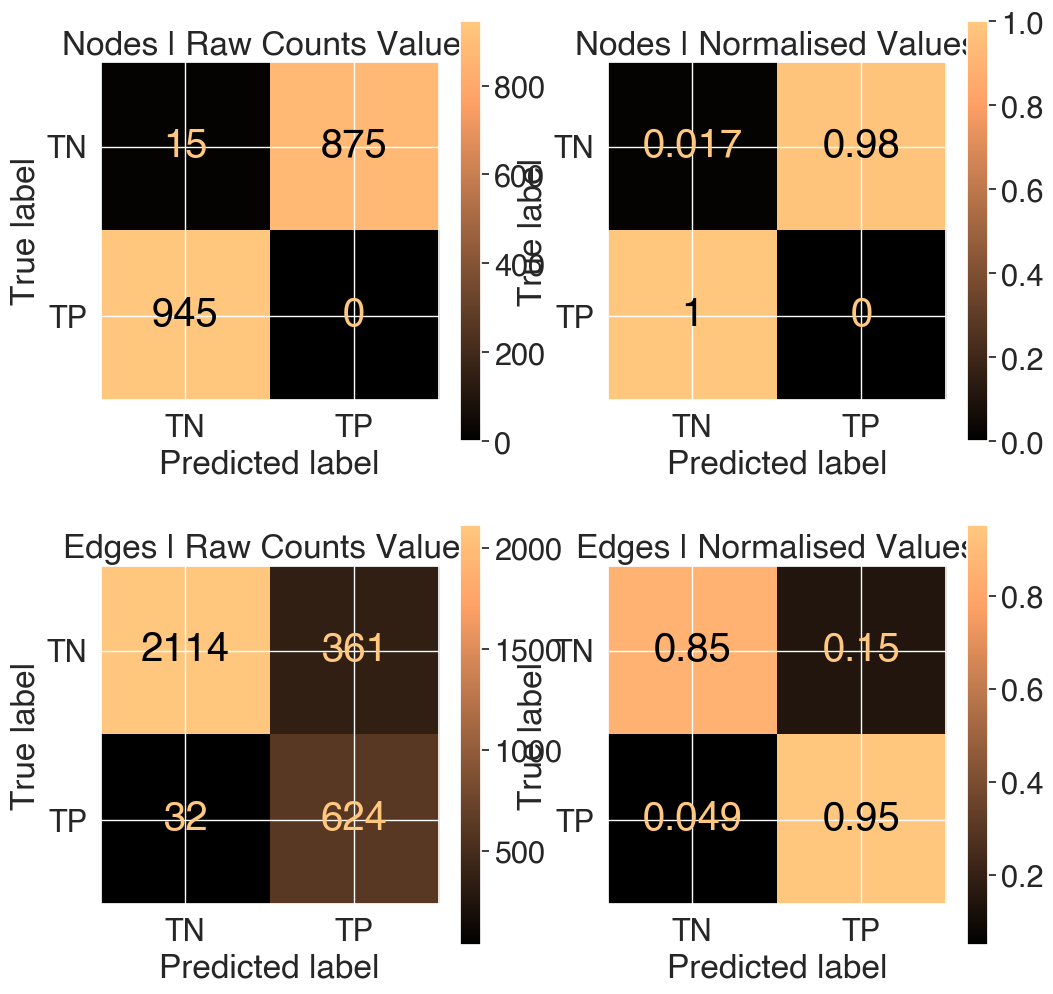

In [19]:
figsize = (12, 12)
colormap = "copper"
confusion_matrix_plotting_data = [
    [node_argmax_preds, node_labels, "nodes"], 
    [edge_argmax_preds, edge_labels, "edges"],
]

_, axs = plt.subplots(2, 2, figsize=figsize)

for d, matrix_data in enumerate(confusion_matrix_plotting_data):
    for n, nrm in enumerate([None, "true"]):
        ConfusionMatrixDisplay.from_predictions(
            y_pred=matrix_data[0],
            y_true=matrix_data[1],
            normalize=nrm,
            ax=axs[d, n],
            cmap=colormap,
            display_labels=["TN", "TP"],
            text_kw={"fontsize": "large"},
        )

        flag = "Raw Counts" if nrm is None else "Normalised"
        text = f"{matrix_data[2].capitalize()} | {flag} Values"
        axs[d, n].set_title(text)

plt.show()


##### Done!